# Testing multiclass classification and using TensorBoard

## Setting

In [4]:
%matplotlib inline
import collections

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from matplotlib import pyplot as plt
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
import datetime
from contextlib import contextmanager

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [5]:
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

In [6]:
data_path = "../data/cifar10/"
cifar10 = datasets.CIFAR10(
    data_path,
    train=True,
    download=True,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616)),
        ]
    ),
)

100.0%


Extracting ../data/cifar10/cifar-10-python.tar.gz to ../data/cifar10/


In [7]:
cifar10_val = datasets.CIFAR10(
    data_path,
    train=False,
    download=True,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616)),
        ]
    ),
)

Files already downloaded and verified


In [8]:
label_map = {0: 0, 2: 1}
class_names = ["airplane", "bird"]
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

In [9]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training on device {device}.")

Training on device cuda.


## Utilities

In [10]:
def train_epoch(model, train_loader, optimizer, loss_fn, device):
    """Run one epoch of training.
    
    Args:
        model: PyTorch model
        train_loader: Training data loader
        optimizer: PyTorch optimizer
        loss_fn: Loss function
        device: Device to run on
        
    Returns:
        dict: Dictionary containing training metrics
    """
    model.train()
    loss_train = 0.0
    correct_train = 0
    total_train = 0
    
    for imgs, labels in train_loader:
        imgs = imgs.to(device=device)
        labels = labels.to(device=device)
        
        outputs = model(imgs)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_train += loss.item()
        
        _, predicted = torch.max(outputs, dim=1)
        total_train += labels.shape[0]
        correct_train += int((predicted == labels).sum())
    
    # Calculate training metrics
    train_loss = loss_train / len(train_loader)
    train_accuracy = correct_train / total_train
    
    return {
        'loss': train_loss,
        'accuracy': train_accuracy
    }

In [11]:
@contextmanager
def create_summary_writer(model_name, hyperparams=None):
    """Context manager for creating and managing a TensorBoard SummaryWriter.
    
    Args:
        model_name (str): Name of the model for the log directory
        hyperparams (dict, optional): Hyperparameters to log
        
    Yields:
        SummaryWriter: TensorBoard writer
    """
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    model_architecture = hyperparams.get('model_architecture', '') if hyperparams else ''
    log_dir = f"runs/{model_name}_{model_architecture}_{timestamp}"
    writer = SummaryWriter(log_dir)
    
    print(f"TensorBoard logs will be saved to {log_dir}")
    
    if hyperparams:
        # Log hyperparameters as text
        param_str = "\n".join([f"{k}: {v}" for k, v in hyperparams.items()])
        writer.add_text('Hyperparameters', param_str)
    
    try:
        yield writer
    finally:
        writer.close()
        print(f"TensorBoard writer closed for {log_dir}")

In [12]:
def evaluate_model(model, val_loader, loss_fn, device, class_names=None):
    """Evaluate the model on validation data.
    
    Args:
        model: PyTorch model
        val_loader: Validation data loader
        loss_fn: Loss function
        device: Device to run on
        class_names (list, optional): List of class names
        
    Returns:
        dict: Dictionary containing validation metrics and predictions
    """
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, dim=1)
            total_val += labels.shape[0]
            correct_val += int((predicted == labels).sum())
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate validation metrics
    val_loss = val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    val_f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return {
        'loss': val_loss,
        'accuracy': val_accuracy,
        'f1': val_f1,
        'predictions': all_preds,
        'true_labels': all_labels
    }

In [13]:
def log_metrics(writer, train_metrics, val_metrics, optimizer, epoch):
    """Log metrics to TensorBoard.
    
    Args:
        writer: TensorBoard SummaryWriter
        train_metrics (dict): Training metrics
        val_metrics (dict): Validation metrics
        optimizer: PyTorch optimizer
        epoch (int): Current epoch
    """
    # Log scalar metrics
    writer.add_scalar('Loss/train', train_metrics['loss'], epoch)
    writer.add_scalar('Loss/validation', val_metrics['loss'], epoch)
    writer.add_scalar('Accuracy/train', train_metrics['accuracy'], epoch)
    writer.add_scalar('Accuracy/validation', val_metrics['accuracy'], epoch)
    writer.add_scalar('F1/validation', val_metrics['f1'], epoch)
    
    # Log learning rate
    writer.add_scalar('Learning_Rate', optimizer.param_groups[0]['lr'], epoch)

In [14]:
def log_model_info(writer, model, epoch, train_loader, device):
    """Log model parameters and gradients to TensorBoard.
    
    Args:
        writer: TensorBoard SummaryWriter
        model: PyTorch model
        epoch (int): Current epoch
        train_loader: Training data loader
        device: Device to run on
    """
    # Log model graph (only once)
    if epoch == 1:
        example_images, _ = next(iter(train_loader))
        try:
            writer.add_graph(model, example_images.to(device))
        except Exception as e:
            print(f"Failed to add model graph to TensorBoard: {e}")
    
    # Log histograms of model parameters
    for name, param in model.named_parameters():
        writer.add_histogram(f'Parameters/{name}', param, epoch)
        if param.grad is not None:
            writer.add_histogram(f'Gradients/{name}', param.grad, epoch)

In [15]:
def log_predictions(writer, model, val_loader, device, class_names, epoch, num_images=10):
    """Log prediction visualizations to TensorBoard.
    
    Args:
        writer: TensorBoard SummaryWriter
        model: PyTorch model
        val_loader: Validation data loader
        device: Device to run on
        class_names (list): List of class names
        epoch (int): Current epoch
        num_images (int): Number of images to visualize
    """
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))
    
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(imgs.size()[0]):
                if images_so_far >= num_images:
                    break
                
                ax = plt.subplot(2, num_images//2, images_so_far + 1)
                ax.axis('off')
                ax.set_title(f'pred: {class_names[preds[j]]}\ntrue: {class_names[labels[j]]}',
                           color=("green" if preds[j]==labels[j] else "red"))
                
                # Denormalize and convert to numpy for matplotlib
                img = imgs[j].cpu().numpy().transpose((1, 2, 0))
                mean = np.array([0.4915, 0.4823, 0.4468])
                std = np.array([0.2470, 0.2435, 0.2616])
                img = std * img + mean
                img = np.clip(img, 0, 1)
                
                plt.imshow(img)
                images_so_far += 1
                if images_so_far >= num_images:
                    break
    
    writer.add_figure(f'Predictions/Epoch_{epoch}', fig, epoch)
    plt.close(fig)

In [16]:
def log_embeddings(writer, model, val_loader, device, class_names, n_epochs):
    """Log embeddings to TensorBoard.
    
    Args:
        writer: TensorBoard SummaryWriter
        model: PyTorch model
        val_loader: Validation data loader
        device: Device to run on
        class_names (list): List of class names
        n_epochs (int): Total number of epochs
    """
    features = []
    labels_list = []
    
    # Get features from the last layer before classification
    def hook_fn(module, input, output):
        features.append(input[0].cpu().numpy())
    
    # Register hook to the second-to-last layer
    try:
        handle = model.fc1.register_forward_hook(hook_fn)
        
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs = imgs.to(device)
                model(imgs)
                labels_list.extend(labels.numpy())
        
        handle.remove()
        
        # Concatenate all features
        features = np.concatenate(features)
        
        # Select a subset of data for visualization (max 10000 points)
        max_samples = min(10000, len(features))
        indices = np.random.choice(len(features), max_samples, replace=False)
        
        # Log embeddings
        writer.add_embedding(
            features[indices],
            metadata=[class_names[l] for l in np.array(labels_list)[indices]],
            label_img=None,
            global_step=n_epochs
        )
    except Exception as e:
        print(f"Failed to log embeddings to TensorBoard: {e}")

In [17]:
class EarlyStopping:
    """Early stopping to terminate training when validation loss doesn't improve.
    
    Args:
        patience (int): How many epochs to wait after last improvement.
        min_delta (float): Minimum change to qualify as an improvement.
        mode (str): 'min' for monitoring metrics that decrease (like loss),
                    'max' for metrics that increase (like accuracy).
        verbose (bool): If True, prints a message for each improvement.
    """
    def __init__(self, patience=10, min_delta=0.0, mode='min', verbose=False):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_epoch = 0
        
        # Set the direction based on mode
        self.monitor_op = np.less if mode == 'min' else np.greater
        self.min_delta = min_delta if mode == 'min' else -min_delta
        
    def __call__(self, epoch, current_score, model=None, path=None):
        """Check if training should be stopped.
        
        Args:
            epoch (int): Current epoch number
            current_score (float): Current validation metric to monitor
            model (torch.nn.Module, optional): Model to save if score improves
            path (str, optional): Path to save the model
            
        Returns:
            bool: True if training should stop, False otherwise
        """
        if self.best_score is None:
            # First epoch
            self.best_score = current_score
            self.best_epoch = epoch
            self.save_checkpoint(current_score, model, path)
        elif self.monitor_op(current_score - self.min_delta, self.best_score):
            # Score improved
            self.best_score = current_score
            self.best_epoch = epoch
            self.counter = 0
            self.save_checkpoint(current_score, model, path)
        else:
            # Score did not improve
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                
        return self.early_stop
    
    def save_checkpoint(self, score, model, path):
        """Save model when validation score improves."""
        if self.verbose:
            improved = 'improved' if self.best_score == score else 'did not improve'
            metric_name = 'loss' if self.mode == 'min' else 'score'
            print(f'Validation {metric_name} {improved} ({self.best_score:.6f} --> {score:.6f})')
        
        if model is not None and path is not None:
            torch.save(model.state_dict(), path)
            if self.verbose:
                print(f'Model saved to {path}')

In [18]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader, 
                  epoch_trainer, device, class_names, model_name="model", 
                  early_stopping_params=None):
    """Main training loop with TensorBoard logging and early stopping.
    
    Args:
        n_epochs (int): Maximum number of epochs
        optimizer: PyTorch optimizer
        model: PyTorch model
        loss_fn: Loss function
        train_loader: Training data loader
        val_loader: Validation data loader
        device: Device to run on
        class_names (list): List of class names
        model_name (str): Name for the model in logs
        early_stopping_params (dict, optional): Parameters for early stopping
            {
                'patience': int,
                'min_delta': float,
                'metric': str ('loss', 'accuracy', or 'f1'),
                'mode': str ('min' or 'max')
            }
        
    Returns:
        dict: Dictionary containing best metrics
    """
    print(f"Training on device {device}")
    
    # Move model to device
    model.to(device=device)
    
    # Setup early stopping if parameters are provided
    early_stopping = None
    if early_stopping_params:
        metric = early_stopping_params.get('metric', 'f1')
        mode = early_stopping_params.get('mode', 'min' if metric == 'loss' else 'max')
        patience = early_stopping_params.get('patience', 10)
        min_delta = early_stopping_params.get('min_delta', 0.0)
        verbose = early_stopping_params.get('verbose', False)
        
        early_stopping = EarlyStopping(
            patience=patience,
            min_delta=min_delta,
            mode=mode,
            verbose=verbose
        )
        
        print(f"Early stopping enabled: monitoring {metric}, mode={mode}, patience={patience}")
    
    # Create hyperparameters dict for logging
    hyperparams = {
        'batch_size': train_loader.batch_size,
        'learning_rate': optimizer.param_groups[0]['lr'],
        'weight_decay': optimizer.param_groups[0].get('weight_decay', 0),
        'epochs': n_epochs,
        'optimizer': optimizer.__class__.__name__,
        'model_architecture': model.__class__.__name__,
    }
    
    if early_stopping_params:
        hyperparams.update({
            'early_stopping_metric': early_stopping_params.get('metric', 'loss'),
            'early_stopping_patience': early_stopping_params.get('patience', 10),
            'early_stopping_min_delta': early_stopping_params.get('min_delta', 0.0),
        })
    
    # Create TensorBoard writer using context manager
    with create_summary_writer(model_name, hyperparams) as writer:
        best_val_f1 = 0.0
        best_metrics = {}
        
        for epoch in range(1, n_epochs + 1):
            # Train for one epoch
            train_metrics = epoch_trainer(model, train_loader, optimizer, loss_fn, device)
            
            # Evaluate the model
            val_metrics = evaluate_model(model, val_loader, loss_fn, device, class_names)
            
            # Log metrics to TensorBoard
            log_metrics(writer, train_metrics, val_metrics, optimizer, epoch)
            
            # Log model information periodically
            if epoch % 10 == 0 or epoch == 1:
                log_model_info(writer, model, epoch, train_loader, device)
                log_predictions(writer, model, val_loader, device, class_names, epoch)
            
            # Print metrics periodically
            if epoch == 1 or epoch % 5 == 0:
                print(f"{datetime.datetime.now()} Epoch {epoch}")
                print(f"  Training:   Loss: {train_metrics['loss']:.4f}, Accuracy: {train_metrics['accuracy']:.4f}")
                print(f"  Validation: Loss: {val_metrics['loss']:.4f}, Accuracy: {val_metrics['accuracy']:.4f}, F1: {val_metrics['f1']:.4f}")
            
            # Save best model based on F1 score
            if val_metrics['f1'] > best_val_f1:
                best_val_f1 = val_metrics['f1']
                best_metrics = val_metrics.copy()
                torch.save(model.state_dict(), f"runs/{model_name}_best_model.pth")
            
            # Check early stopping condition
            if early_stopping:
                # Get the metric to monitor
                metric_name = early_stopping_params.get('metric', 'loss')
                current_metric = val_metrics[metric_name]
                
                # Call early stopping with current metric
                model_path = f"runs/{model_name}_early_stopping.pth"
                if early_stopping(epoch, current_metric, model, model_path):
                    print(f"Early stopping triggered at epoch {epoch}")
                    print(f"Best {metric_name} was at epoch {early_stopping.best_epoch}")
                    break
        
        # Log embeddings after training is complete
        log_embeddings(writer, model, val_loader, device, class_names, epoch)
        
        # Log final hyperparameters with metrics
        final_metrics = {
            'hparam/val_accuracy': val_metrics['accuracy'],
            'hparam/val_f1': val_metrics['f1'],
            'hparam/val_loss': val_metrics['loss'],
            'hparam/epochs_trained': epoch
        }
        writer.add_hparams(hyperparams, final_metrics)
    
    # Set the model to evaluation mode after training
    model.eval()
    print(f"Training complete. Best validation F1: {best_val_f1:.4f}")
    
    # If early stopping was used, report the best epoch
    if early_stopping:
        print(f"Best {early_stopping_params.get('metric', 'loss')} was at epoch {early_stopping.best_epoch}")
    
    return best_metrics

## Testing models

In [19]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=512, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=512, shuffle=False)
all_acc_dict = collections.OrderedDict()

### Hyperparameters

In [20]:
model_name = "cifar2_model"
n_epochs = 200
early_stopping_params = {
    'metric': 'f1',      # Monitor F1 score
    'mode': 'max',       # We want to maximize F1
    'patience': 5,       # Wait for 5 epochs before stopping
    'min_delta': 0.001   # Minimum change to qualify as improvement
}

### Baseline

In [21]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [22]:
# We transfer the model (all its parameters) to the device.
model = Net().to(device=device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

all_acc_dict["baseline"] = training_loop(
    n_epochs=n_epochs,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    epoch_trainer=train_epoch,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    class_names=class_names,
    model_name=model_name,
    early_stopping_params=early_stopping_params,
)

Training on device cuda
Early stopping enabled: monitoring f1, mode=max, patience=5
TensorBoard logs will be saved to runs/cifar2_model_Net_20250411-092501
2025-04-11 09:25:06.186187 Epoch 1
  Training:   Loss: 0.5445, Accuracy: 0.7376
  Validation: Loss: 0.4538, Accuracy: 0.7955, F1: 0.7955
2025-04-11 09:25:06.754963 Epoch 5
  Training:   Loss: 0.3390, Accuracy: 0.8509
  Validation: Loss: 0.3317, Accuracy: 0.8505, F1: 0.8505
2025-04-11 09:25:07.889733 Epoch 10
  Training:   Loss: 0.2932, Accuracy: 0.8755
  Validation: Loss: 0.3069, Accuracy: 0.8650, F1: 0.8649
2025-04-11 09:25:08.666838 Epoch 15
  Training:   Loss: 0.2647, Accuracy: 0.8873
  Validation: Loss: 0.2921, Accuracy: 0.8720, F1: 0.8720
2025-04-11 09:25:09.870773 Epoch 20
  Training:   Loss: 0.2429, Accuracy: 0.8978
  Validation: Loss: 0.2858, Accuracy: 0.8785, F1: 0.8785
2025-04-11 09:25:10.637587 Epoch 25
  Training:   Loss: 0.2227, Accuracy: 0.9078
  Validation: Loss: 0.2833, Accuracy: 0.8830, F1: 0.8830
Early stopping tri

### Augmenting width or channels in convolutions

In [23]:
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [24]:
model = NetWidth(n_chans1=32).to(device=device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

all_acc_dict["width"] = training_loop(
    n_epochs=n_epochs,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    epoch_trainer=train_epoch,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    class_names=class_names,
    model_name=model_name,
    early_stopping_params=early_stopping_params,
)

Training on device cuda
Early stopping enabled: monitoring f1, mode=max, patience=5
TensorBoard logs will be saved to runs/cifar2_model_NetWidth_20250411-092512
2025-04-11 09:25:13.141306 Epoch 1
  Training:   Loss: 0.4999, Accuracy: 0.7629
  Validation: Loss: 0.4134, Accuracy: 0.8140, F1: 0.8138
2025-04-11 09:25:13.785222 Epoch 5
  Training:   Loss: 0.3268, Accuracy: 0.8617
  Validation: Loss: 0.3215, Accuracy: 0.8565, F1: 0.8565
2025-04-11 09:25:15.005048 Epoch 10
  Training:   Loss: 0.2721, Accuracy: 0.8852
  Validation: Loss: 0.2834, Accuracy: 0.8805, F1: 0.8805
2025-04-11 09:25:15.833605 Epoch 15
  Training:   Loss: 0.2248, Accuracy: 0.9049
  Validation: Loss: 0.2769, Accuracy: 0.8915, F1: 0.8914
2025-04-11 09:25:17.074308 Epoch 20
  Training:   Loss: 0.1900, Accuracy: 0.9217
  Validation: Loss: 0.2715, Accuracy: 0.8965, F1: 0.8964
2025-04-11 09:25:17.891685 Epoch 25
  Training:   Loss: 0.1593, Accuracy: 0.9357
  Validation: Loss: 0.2753, Accuracy: 0.8955, F1: 0.8954
Early stoppin

### $L_2$-regularizarion

In [25]:
def l2_epoch_trainer(model, train_loader, optimizer, loss_fn, device):
    """Run one epoch of training.
    
    Args:
        model: PyTorch model
        train_loader: Training data loader
        optimizer: PyTorch optimizer
        loss_fn: Loss function
        device: Device to run on
        
    Returns:
        dict: Dictionary containing training metrics
    """
    model.train()
    loss_train = 0.0
    correct_train = 0
    total_train = 0
    
    for imgs, labels in train_loader:
        imgs = imgs.to(device=device)
        labels = labels.to(device=device)
        
        outputs = model(imgs)
        loss = loss_fn(outputs, labels)

        l2_lambda = 0.001
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
        loss = loss + l2_lambda * l2_norm

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_train += loss.item()
        
        _, predicted = torch.max(outputs, dim=1)
        total_train += labels.shape[0]
        correct_train += int((predicted == labels).sum())
    
    # Calculate training metrics
    train_loss = loss_train / len(train_loader)
    train_accuracy = correct_train / total_train
    
    return {
        'loss': train_loss,
        'accuracy': train_accuracy
    }

In [26]:
model = Net().to(device=device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

all_acc_dict["l2 reg"] = training_loop(
    n_epochs=n_epochs,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    epoch_trainer=l2_epoch_trainer,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    class_names=class_names,
    model_name=model_name,
    early_stopping_params=early_stopping_params,
)

Training on device cuda
Early stopping enabled: monitoring f1, mode=max, patience=5
TensorBoard logs will be saved to runs/cifar2_model_Net_20250411-092519
2025-04-11 09:25:20.447757 Epoch 1
  Training:   Loss: 0.5695, Accuracy: 0.7388
  Validation: Loss: 0.4644, Accuracy: 0.7970, F1: 0.7961
2025-04-11 09:25:21.217283 Epoch 5
  Training:   Loss: 0.3707, Accuracy: 0.8480
  Validation: Loss: 0.3395, Accuracy: 0.8495, F1: 0.8495
2025-04-11 09:25:22.771159 Epoch 10
  Training:   Loss: 0.3290, Accuracy: 0.8694
  Validation: Loss: 0.3126, Accuracy: 0.8585, F1: 0.8584
2025-04-11 09:25:23.731536 Epoch 15
  Training:   Loss: 0.3011, Accuracy: 0.8829
  Validation: Loss: 0.2887, Accuracy: 0.8710, F1: 0.8710
2025-04-11 09:25:25.091567 Epoch 20
  Training:   Loss: 0.2833, Accuracy: 0.8925
  Validation: Loss: 0.2825, Accuracy: 0.8770, F1: 0.8768
2025-04-11 09:25:26.054980 Epoch 25
  Training:   Loss: 0.2663, Accuracy: 0.8997
  Validation: Loss: 0.2713, Accuracy: 0.8810, F1: 0.8810
2025-04-11 09:25:2

### Dropout

In [27]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [28]:
model = NetDropout(n_chans1=32).to(device=device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

all_acc_dict["dropout"] = training_loop(
    n_epochs=n_epochs,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    epoch_trainer=train_epoch,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    class_names=class_names,
    model_name=model_name,
    early_stopping_params=early_stopping_params,
)

Training on device cuda
Early stopping enabled: monitoring f1, mode=max, patience=5
TensorBoard logs will be saved to runs/cifar2_model_NetDropout_20250411-092531
2025-04-11 09:25:32.129572 Epoch 1
  Training:   Loss: 0.5404, Accuracy: 0.7371
  Validation: Loss: 0.4412, Accuracy: 0.7990, F1: 0.7990
2025-04-11 09:25:32.824306 Epoch 5
  Training:   Loss: 0.3803, Accuracy: 0.8302
  Validation: Loss: 0.3457, Accuracy: 0.8440, F1: 0.8440
2025-04-11 09:25:34.306563 Epoch 10
  Training:   Loss: 0.3373, Accuracy: 0.8528
  Validation: Loss: 0.3133, Accuracy: 0.8590, F1: 0.8590
2025-04-11 09:25:35.181112 Epoch 15
  Training:   Loss: 0.3119, Accuracy: 0.8695
  Validation: Loss: 0.2923, Accuracy: 0.8705, F1: 0.8705
2025-04-11 09:25:36.461765 Epoch 20
  Training:   Loss: 0.2821, Accuracy: 0.8796
  Validation: Loss: 0.2759, Accuracy: 0.8810, F1: 0.8810
2025-04-11 09:25:37.342106 Epoch 25
  Training:   Loss: 0.2567, Accuracy: 0.8928
  Validation: Loss: 0.2707, Accuracy: 0.8870, F1: 0.8870
2025-04-11 

### Batch normalization

In [29]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [30]:
model = NetBatchNorm(n_chans1=32).to(device=device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

all_acc_dict["batch_norm"] = training_loop(
    n_epochs=n_epochs,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    epoch_trainer=train_epoch,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    class_names=class_names,
    model_name=model_name,
    early_stopping_params=early_stopping_params,
)

Training on device cuda
Early stopping enabled: monitoring f1, mode=max, patience=5
TensorBoard logs will be saved to runs/cifar2_model_NetBatchNorm_20250411-092542
2025-04-11 09:25:43.761110 Epoch 1
  Training:   Loss: 0.4499, Accuracy: 0.7862
  Validation: Loss: 0.3632, Accuracy: 0.8395, F1: 0.8395
2025-04-11 09:25:44.535547 Epoch 5
  Training:   Loss: 0.2838, Accuracy: 0.8792
  Validation: Loss: 0.3181, Accuracy: 0.8605, F1: 0.8604
2025-04-11 09:25:45.914809 Epoch 10
  Training:   Loss: 0.2207, Accuracy: 0.9081
  Validation: Loss: 0.2663, Accuracy: 0.8935, F1: 0.8935
2025-04-11 09:25:46.888635 Epoch 15
  Training:   Loss: 0.1678, Accuracy: 0.9362
  Validation: Loss: 0.2763, Accuracy: 0.8950, F1: 0.8950
2025-04-11 09:25:48.290251 Epoch 20
  Training:   Loss: 0.1243, Accuracy: 0.9570
  Validation: Loss: 0.2820, Accuracy: 0.9000, F1: 0.9000
2025-04-11 09:25:49.230193 Epoch 25
  Training:   Loss: 0.0993, Accuracy: 0.9650
  Validation: Loss: 0.3196, Accuracy: 0.8930, F1: 0.8927
Early sto

### Augmenting depth

In [31]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [32]:
model = NetDepth(n_chans1=32).to(device=device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

all_acc_dict["depth"] = training_loop(
    n_epochs=n_epochs,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    epoch_trainer=train_epoch,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    class_names=class_names,
    model_name=model_name,
    early_stopping_params=early_stopping_params,
)

Training on device cuda
Early stopping enabled: monitoring f1, mode=max, patience=5
TensorBoard logs will be saved to runs/cifar2_model_NetDepth_20250411-092551
2025-04-11 09:25:51.837536 Epoch 1
  Training:   Loss: 0.5904, Accuracy: 0.7185
  Validation: Loss: 0.4620, Accuracy: 0.8025, F1: 0.8021
2025-04-11 09:25:52.521260 Epoch 5
  Training:   Loss: 0.3324, Accuracy: 0.8581
  Validation: Loss: 0.3293, Accuracy: 0.8525, F1: 0.8525
2025-04-11 09:25:54.011008 Epoch 10
  Training:   Loss: 0.2869, Accuracy: 0.8805
  Validation: Loss: 0.2885, Accuracy: 0.8765, F1: 0.8765
2025-04-11 09:25:54.887371 Epoch 15
  Training:   Loss: 0.2539, Accuracy: 0.8954
  Validation: Loss: 0.2643, Accuracy: 0.8875, F1: 0.8875
2025-04-11 09:25:56.212114 Epoch 20
  Training:   Loss: 0.2311, Accuracy: 0.9039
  Validation: Loss: 0.2536, Accuracy: 0.8930, F1: 0.8930
2025-04-11 09:25:57.093977 Epoch 25
  Training:   Loss: 0.2144, Accuracy: 0.9125
  Validation: Loss: 0.2497, Accuracy: 0.8975, F1: 0.8975
2025-04-11 09

### Residual connections (ResNets) or skip connections

In [33]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [34]:
model = NetRes(n_chans1=32).to(device=device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

all_acc_dict["res"] = training_loop(
    n_epochs=n_epochs,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    epoch_trainer=train_epoch,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    class_names=class_names,
    model_name=model_name,
    early_stopping_params=early_stopping_params,
)

Training on device cuda
Early stopping enabled: monitoring f1, mode=max, patience=5
TensorBoard logs will be saved to runs/cifar2_model_NetRes_20250411-092603
2025-04-11 09:26:04.369387 Epoch 1
  Training:   Loss: 0.5827, Accuracy: 0.7130
  Validation: Loss: 0.4473, Accuracy: 0.8140, F1: 0.8139
2025-04-11 09:26:05.117676 Epoch 5
  Training:   Loss: 0.3327, Accuracy: 0.8583
  Validation: Loss: 0.3229, Accuracy: 0.8560, F1: 0.8560
2025-04-11 09:26:06.456171 Epoch 10
  Training:   Loss: 0.2926, Accuracy: 0.8796
  Validation: Loss: 0.2908, Accuracy: 0.8720, F1: 0.8720
2025-04-11 09:26:07.354682 Epoch 15
  Training:   Loss: 0.2651, Accuracy: 0.8922
  Validation: Loss: 0.2749, Accuracy: 0.8800, F1: 0.8800
2025-04-11 09:26:08.680805 Epoch 20
  Training:   Loss: 0.2408, Accuracy: 0.9003
  Validation: Loss: 0.2631, Accuracy: 0.8875, F1: 0.8875
2025-04-11 09:26:09.598941 Epoch 25
  Training:   Loss: 0.2204, Accuracy: 0.9091
  Validation: Loss: 0.2541, Accuracy: 0.8940, F1: 0.8940
2025-04-11 09:2

In [35]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(
            n_chans, n_chans, kernel_size=3, padding=1, bias=False
        )  # <1>
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity="relu")  # <2>
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

In [36]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(*(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

## Final model

In [37]:
def final_evaluation(model_class, model_path, test_loader, device, class_names):
    """
    Perform final evaluation of the model on the test set.
    
    Args:
        model_path: Path to the saved model weights
        test_loader: DataLoader for test data
        device: Device to run on
        class_names: List of class names
    
    Returns:
        dict: Dictionary containing test metrics
    """
    # Initialize model and load weights
    model = model_class().to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    # Evaluate on test set
    loss_fn = nn.CrossEntropyLoss()
    test_metrics = evaluate_model(model, test_loader, loss_fn, device, class_names)
    
    # Print comprehensive results
    print("\n===== FINAL MODEL EVALUATION =====")
    print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Test F1 Score: {test_metrics['f1']:.4f}")
    
    # Calculate per-class metrics
    y_true = np.array(test_metrics['true_labels'])
    y_pred = np.array(test_metrics['predictions'])
    
    # Precision, recall per class
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)
    
    print("\nPer-class performance:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name:10s}: Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1: {f1[i]:.4f}")
    
    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Add text annotations to confusion matrix
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    return test_metrics


===== FINAL MODEL EVALUATION =====
Test Accuracy: 0.9025
Test F1 Score: 0.9024

Per-class performance:
airplane  : Precision: 0.8808, Recall: 0.9310, F1: 0.9052
bird      : Precision: 0.9268, Recall: 0.8740, F1: 0.8996


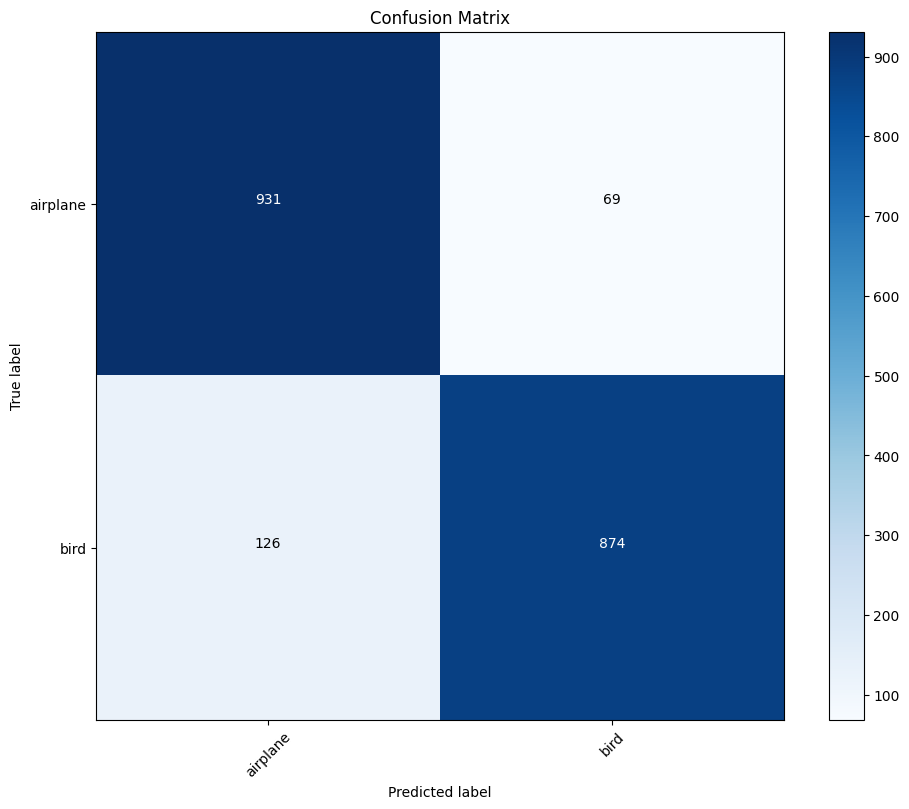

In [38]:
best_model_path = "runs/cifar2_model_best_model.pth"
test_metrics = final_evaluation(NetRes, best_model_path, val_loader, device, class_names)